<a href="https://colab.research.google.com/github/qarzu383-coder/DL-Exam-Task14-Arzu-Quliyeva/blob/main/Flowers_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time

# SEED SETUP (S214 - Quliyeva Arzu üçün)
SEED = 20240214
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Cihaz: {device}")


Cihaz: cuda


In [4]:
# Kaggle Flowers Datasetini yükləmək (Colab üçün)
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
!tar -xvf flower_photos.tgz

# REQUIRED TRANSFORMS
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

full_dataset = datasets.ImageFolder(root='flower_photos', transform=transform)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_data, test_data = torch.utils.data.random_split(full_dataset, [train_size, test_size])

classes = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

--2025-12-23 17:17:31--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz.1’

flower_photos.tgz.1 100%[===================>] 218.21M   271MB/s    in 0.8s    

2025-12-23 17:17:31 (271 MB/s) - ‘flower_photos.tgz.1’ saved [228813984/228813984]

flower_photos/
flower_photos/roses/
flower_photos/roses/14810868100_87eb739f26_m.jpg
flower_photos/roses/1446090416_f0cad5fde4.jpg
flower_photos/roses/15319767030_e6c5602a77_m.jpg
flower_photos/roses/15032112248_30c5284e54_n.jpg
flower_photos/roses/7211616670_2d49ecb3a5_m.jpg
flower_photos/roses/15674450867_0ced942941_n.jpg
flower_photos/roses/17158274118_00ec99a23c.jpg
fl

In [8]:
def get_model():
    # 1. Load pre-trained ResNet18
    model = models.resnet18(weights='IMAGENET1K_V1')

    # 2. Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # 3. Replace final layer (512 -> 5)
    model.fc = nn.Linear(512, 5)
    return model.to(device)

In [9]:
def train_model(version_name, optimizer_cfg, batch_size):
    loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    model = get_model()
    criterion = nn.CrossEntropyLoss()

    if optimizer_cfg['type'] == 'Adam':
        optimizer = optim.Adam(model.fc.parameters(), lr=optimizer_cfg['lr'])
    else: # Option C: SGD
        optimizer = optim.SGD(model.fc.parameters(), lr=optimizer_cfg['lr'], momentum=0.9)

    history = {'loss': [], 'acc': []}

    print(f"\n--- {version_name} Başlayır ---")
    for epoch in range(10): # Epochs: 10
        model.train()
        r_loss = 0.0
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            r_loss += loss.item()

        # Eval
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                out = model(imgs)
                _, pred = torch.max(out, 1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()

        acc = 100 * correct / total
        history['loss'].append(r_loss/len(loader))
        history['acc'].append(acc)
        print(f"Epoch {epoch+1}: Loss {r_loss/len(loader):.4f}, Acc {acc:.2f}%")

    return model, history

In [11]:
def get_model():
    # 1. Load pre-trained ResNet18
    model = models.resnet18(weights='IMAGENET1K_V1')

    # 2. Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # 3. Replace final layer (512 -> 5)
    model.fc = nn.Linear(512, 5)
    return model.to(device)

In [13]:
# Version 1: Adam, LR 0.0001, Batch 32
v1_cfg = {'type': 'Adam', 'lr': 0.0001}
model_v1, hist_v1 = train_model("Version 1", v1_cfg, 32)

# Version 2: Option C (SGD, LR 0.001, Momentum 0.9, Batch 32)
v2_cfg = {'type': 'SGD', 'lr': 0.001}
model_v2, hist_v2 = train_model("Version 2 (Option C)", v2_cfg, 32)


--- Version 1 Başlayır ---
Epoch 1: Loss 1.5623, Acc 44.01%
Epoch 2: Loss 1.2536, Acc 63.62%
Epoch 3: Loss 1.0500, Acc 72.48%
Epoch 4: Loss 0.9078, Acc 74.80%
Epoch 5: Loss 0.8072, Acc 78.75%
Epoch 6: Loss 0.7380, Acc 79.84%
Epoch 7: Loss 0.6794, Acc 81.61%
Epoch 8: Loss 0.6324, Acc 83.51%
Epoch 9: Loss 0.5941, Acc 83.51%
Epoch 10: Loss 0.5659, Acc 84.88%

--- Version 2 (Option C) Başlayır ---
Epoch 1: Loss 0.9268, Acc 83.51%
Epoch 2: Loss 0.5077, Acc 85.42%
Epoch 3: Loss 0.4288, Acc 87.60%
Epoch 4: Loss 0.3868, Acc 86.92%
Epoch 5: Loss 0.3631, Acc 88.96%
Epoch 6: Loss 0.3350, Acc 88.96%
Epoch 7: Loss 0.3328, Acc 88.28%
Epoch 8: Loss 0.3193, Acc 88.28%
Epoch 9: Loss 0.3015, Acc 90.74%
Epoch 10: Loss 0.2968, Acc 90.46%


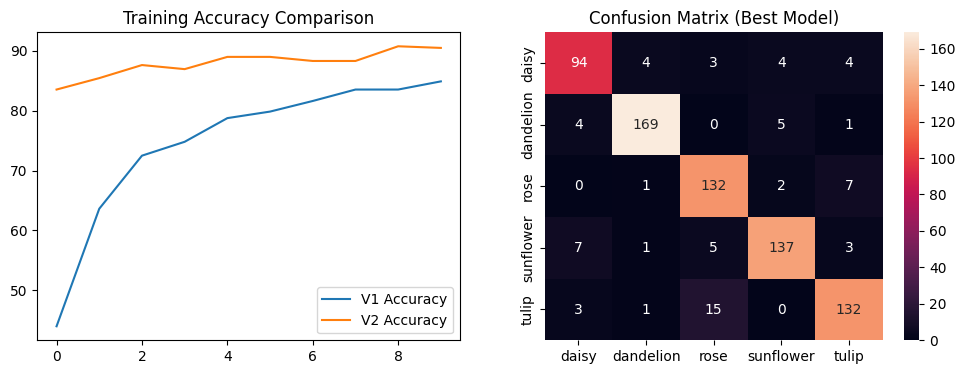


Final Accuracies:
V1: 84.88%
V2: 90.46%


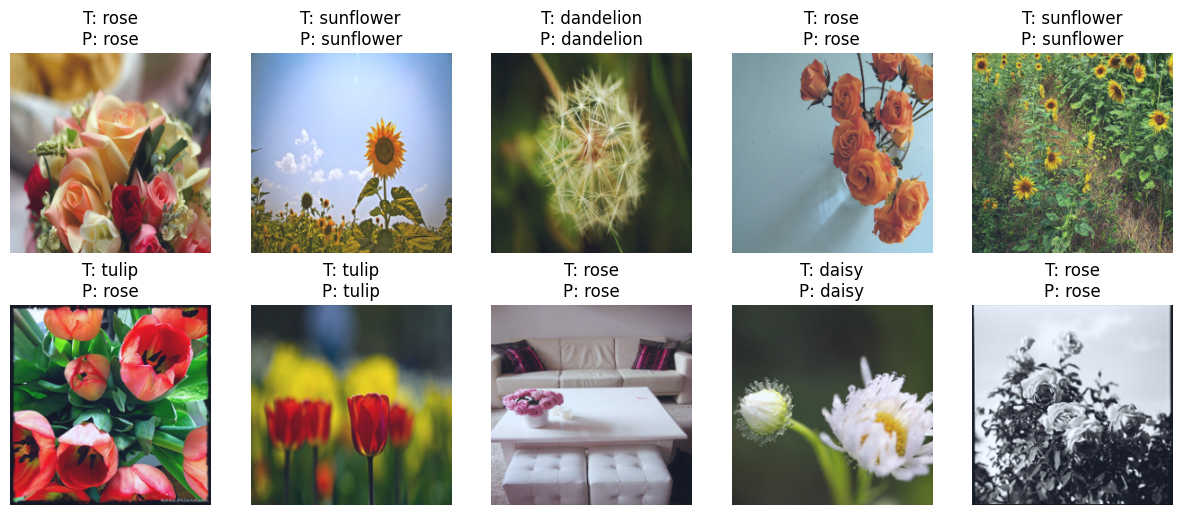

In [14]:
# 1. Comparison Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(hist_v1['acc'], label='V1 Accuracy')
plt.plot(hist_v2['acc'], label='V2 Accuracy')
plt.title('Training Accuracy Comparison')
plt.legend()

# 3. Confusion Matrix (Best Model - Model V2)
plt.subplot(1, 2, 2)
model_v2.eval()
all_p, all_t = [], []
with torch.no_grad():
    for i, l in DataLoader(test_data, batch_size=32):
        outputs = model_v2(i.to(device))
        all_p.extend(torch.max(outputs, 1)[1].cpu().numpy())
        all_t.extend(l.numpy())
    cm = confusion_matrix(all_t, all_p)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix (Best Model)')
    plt.show()

# 2. Comparison Table
print(f"\nFinal Accuracies:\nV1: {hist_v1['acc'][-1]:.2f}%\nV2: {hist_v2['acc'][-1]:.2f}%")

# 4. 10 Sample Predictions
plt.figure(figsize=(15, 6))
for i in range(10):
    img, label = test_data[i]
    output = model_v2(img.unsqueeze(0).to(device))
    pred = torch.max(output, 1)[1].item()
    plt.subplot(2, 5, i+1)
    plt.imshow(img.permute(1, 2, 0).numpy() * 0.2 + 0.5) # De-normalize for visualization
    plt.title(f"T: {classes[label]}\nP: {classes[pred]}")
    plt.axis('off')
plt.show()